<a href="https://colab.research.google.com/github/narayanacharyuluchitroju/DeepLearningModels/blob/main/01_Torchvision_OD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size:30px;">Introduction to Object Detection using Torchvision</h1>

We already know that torchvision contains many popular pre-trained models across classification, object detection, and detection, along with some popular datasets and standard image transformations.

In the previous modules, we have fine-tuned and trained some popular classification models.

In this notebook, we shall explore some popular object detection pre-trained models available at torchvision. We shall get hands-on with the inference through these models using a few sample images, as this is the very first notebook in our object detection module.

## Table of Contents

* [1 What is Object Detection](#1-What-is-Object-Detection?)
* [2 Introduction to Torchvision models for Object Detection](#2-Introduction-to-Torchvision-Models-for-Object-Detection)
* [3 Object Detection Model Inference using Torchvision](#3-Object-Detection-Model-Inference-using-Torchvision)
* [4 References](#4-References)

## 1 What is Object Detection?

Unlike classification, object detection, on the other hand, refers to the task of identifying and localizing objects within an image. The goal of object detection is not only to predict the class label of an object but also to identify the object's location within the image.

For instance, observe the example image shown below. Apart from classifying the two objects as **person** (on the left) and **dog** (on the right), the object detection model also outputs the location (i.e., the coordinates) of where these objects are located.

<img src="https://opencv.org/wp-content/uploads/2023/01/object_detection.png" width="800">

## 2 Introduction to Torchvision Models for Object Detection

The popular object detection models that are currently available at torchvision are:
* Faster R-CNN
* FCOS
* RetinaNet
* SSD
* SSDlite

All of the models above are trained on the popular MS-COCO dataset.

The table below shows the performance metrics (**mean Average Precision** abbreviated as **mAP**) across the various models on the MS-COCO 2017 validation data:

<img src = "https://opencv.org/wp-content/uploads/2023/03/torchvision_object_detection_mscoco_map.png" width=800>

If the above terms seem overwhelming, do not worry! For now, **mAP** can be considered a means to evaluate the model performance in object detection. We shall cover more on them as we dive deeper through this module.

To learn more about the models across various domains, you can go through the documentation [here](https://pytorch.org/vision/stable/models.html#object-detection).

We begin by importing the necessary dependencies.

In [ ]:
import numpy as np
import torch

import urllib.request as request
import io
import zipfile
import os
import requests

import matplotlib
import matplotlib.pyplot as plt

import cv2
from PIL import Image

In [ ]:
from torchvision.models.detection import (
        fasterrcnn_resnet50_fpn_v2,
        FasterRCNN_ResNet50_FPN_V2_Weights,
        retinanet_resnet50_fpn_v2,
        RetinaNet_ResNet50_FPN_V2_Weights,
        ssd300_vgg16,
        SSD300_VGG16_Weights
)

### 2.1 Utilities and Helper Functions


#### Load Image from Path or URL

`load_image_into_numpy_array()` is a helper function to load an image. We have two options for loading an image:
* through a path specified as an URL
* through a path specified as a file

In [ ]:
def load_image_into_pil_image(path):
    """Load an image from file into a PIL image.

    Args:
    path: the file path to the image.

    Returns:
    uint8 PIL Image.
    """

    image = None
    if(path.startswith('http')):
        with request.urlopen(path) as response:
            image_data = io.BytesIO(bytearray(response.read()))
            image = Image.open(image_data).convert("RGB")

    else:
        image = Image.open(path).convert("RGB")

    return image


`category_index` is a dictionary that maps all 80 classes in the MS-COCO dataset with thier associated class ids.

#### ClassID to RGB Map

We will use `COLOR_IDS` to map each class with a unique RGB color.

In [ ]:
R = np.array(np.arange(0, 256, 32))
G = np.roll(R, 2)
B = np.roll(R, 4)

COLOR_IDS = np.array(np.meshgrid(R, G, B)).T.reshape(-1, 3)

## 3 Object Detection Model Inference using Torchvision

Since this is the first notebook on object detection, we will use pre-trained models from torchvision just for inference. We will discuss more about the model architectures and their training as we move further in the course.

The following code cell maps the various model names from Torchvision. In this notebook, we will be dealing with three sets of models: `RetinaNet with ResNet-50 FPN v2`, `SSD_VGG16`, and `Faster RCNN ResNet-50 FPN v2`.

We also provide some sample test images that can be downloaded and then can perform inference.

### 3.1 Model Overview

In the following code cell, we will use the pre-trained models listed below:
- **FASTERRCNN RESNET50_FPN_V2**
- **RETINANET RESNET50 FPN V2**
- **SSD300 VGG16**

### 3.2 Load Sample Images

Let's try the model on some sample images.

We have already provided some sample images that need to be downloaded first. The `download_file` exactly does this.

In [ ]:
def download_file(url, save_name):

    print('Downloading file...')
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)

We need to extract the zip file now that we have downloaded it.

In [ ]:
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all...")
    except:
        print("Invalid file")

Now that we have the utilities for downloading and unzipping let us specify the URL and download and extract the required file.

We also maintain a list containing the file paths for the samples.

In [ ]:
# URL and Name of our test image folder
test_images_url = 'https://www.dropbox.com/s/e2e1lzhy8res4i9/c3_od_test_images.zip?dl=1'
test_images_zip = 'c3_od_test_images.zip'

# Download test images folder
download_file(test_images_url , test_images_zip)

# Extract the zip folder and remove the zip
unzip(test_images_zip)

folder_name = './test_images'
# Load complete image file paths in a list
image_paths = os.listdir(folder_name)
image_paths = [os.path.join(folder_name,  img) for img in image_paths]

Extracted all...


Let us take visualize our sample images by plotting them.

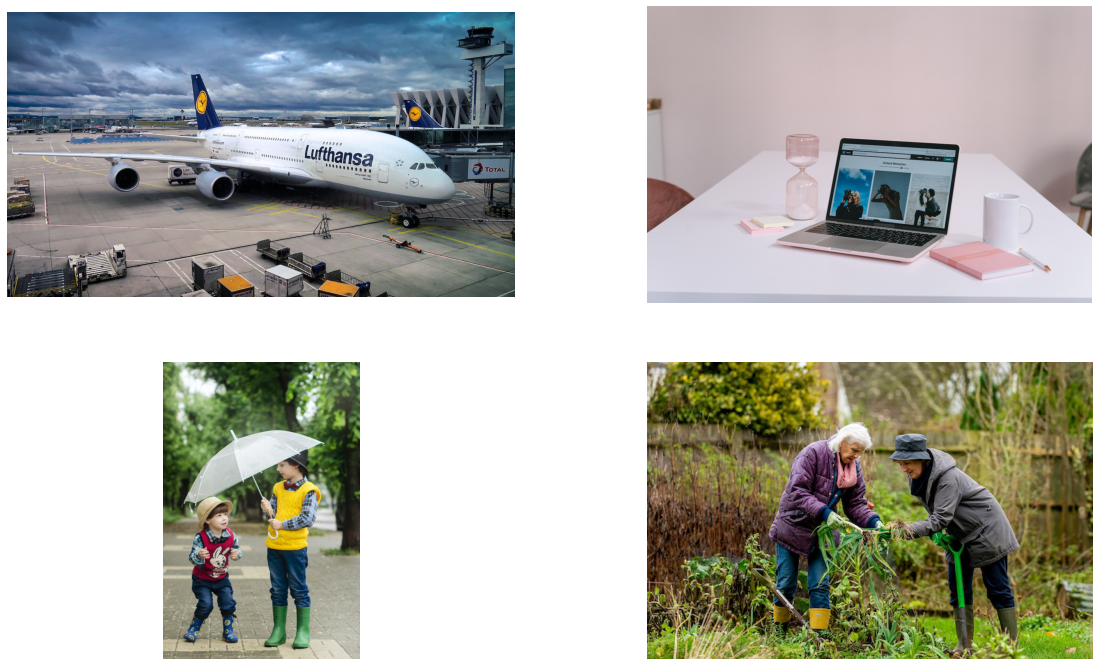

In [ ]:
images = []
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

idx=0
for axis in ax.flat:
    image_pil = load_image_into_pil_image(image_paths[idx])
    images.append(image_pil)
    axis.imshow(image_pil)
    axis.axis('off')
    idx+=1

plt.show(block=False)

### 3.3 Perform Inference

To perform inference, we define the function below, which accepts a list of images, a pre-trained model, the required pre-processing transformations, and the device (`CPU` or `GPU`) used to perform inference.

This `run_inference` function returns a list of dictionaries consisting of the absolute bounding box coordinates, the class labels and their corresponding confidence scores.

In [ ]:
# Running inference.
def run_inference(images, model, transforms, device):

    model.to(device)
    model.eval()
    results_final= []

    with torch.no_grad():
        for img in images:

            # Perform the required pre-processing before passing it though the model.
            img_preprocess = transforms(img).to(device)
            predictions = model(img_preprocess.unsqueeze(dim=0))
            result = {key:value.detach().cpu().numpy() for key,value in predictions[0].items()}

            results_final.append(result)

    return results_final

We need to specify the device on which to perform inference.

In [ ]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

Now, let's use this function perform inference on the sample images using the three models we selected above.

#### Inference with FasterRCNN

`FasterRCNN with ResNet50 FPN V2` is the first model we would perform the inference with. We shall load the model with the best available weights, define the required pre-processing transforms and perform inference.

More details on the Faster RCNN model can be found [here](https://pytorch.org/vision/stable/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn_v2.html#fasterrcnn-resnet50-fpn-v2).

In [ ]:
# Inference from Faster RCNN with ResNet50_FPN backbone.

# Initialize the default (best) weights.
# Also an alias for: FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1
weights_fasterrcnn_r50_v2 = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT

# Initialize the inference transforms.
preprocess_fasterrcnn = weights_fasterrcnn_r50_v2.transforms()

# Load the model with pretrained weights.
model_fasterrcnn_r50 = fasterrcnn_resnet50_fpn_v2(weights=weights_fasterrcnn_r50_v2)

# Perform inference.
predictions_fasterrcnn = run_inference(images, model_fasterrcnn_r50, preprocess_fasterrcnn, device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth


  0%|          | 0.00/167M [00:00<?, ?B/s]

#### Inference with RetinaNet

Next, we perform inference with the `RetinaNet ResNet-50 FPN v2` model using the similar steps that we performed above.

To know more about the other arguments the model accepts, you can look at the [documentation](https://pytorch.org/vision/stable/models/generated/torchvision.models.detection.retinanet_resnet50_fpn_v2.html#retinanet-resnet50-fpn-v2).

In [ ]:
# Inference from RetinaNet ResNet-50 FPN v2.

# Initialize the default (best) weights.
# Equivalent to: RetinaNet_ResNet50_FPN_V2_Weights.COCO_V1
weights_retinanet_r50_v2 =  RetinaNet_ResNet50_FPN_V2_Weights.DEFAULT

# Define the inference transforms.
preprocess_retinanet = weights_retinanet_r50_v2.transforms()

# Load the model with pretrained weights.
model_retinanet_r50 = retinanet_resnet50_fpn_v2(weights=weights_retinanet_r50_v2)

# Perform inference.
predictions_retinanet = run_inference(images, model_retinanet_r50, preprocess_retinanet, device)

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth


  0%|          | 0.00/146M [00:00<?, ?B/s]

#### Inference with SSD

Lastly, we perform inference with the `SSD300 VGG16` model.

For a deeper understanding of the model's accepted arguments, take a look at the accompanying [documentation](https://pytorch.org/vision/stable/models/generated/torchvision.models.detection.ssd300_vgg16.html#ssd300-vgg16).

In [ ]:
# Inference from SSD VGG 16.

# Initialize the default (best) weights.
# Equivalent to: RSSD300_VGG16_Weights.COCO_V1
weights_ssd300_vgg16 =  SSD300_VGG16_Weights.DEFAULT

# Define the inference transforms.
preprocess_ssd = weights_ssd300_vgg16.transforms()

# Load the model with pretrained weights.
model_ssd_vgg16 = ssd300_vgg16(weights=weights_ssd300_vgg16)

# Perform inference.
predictions_ssd = run_inference(images, model_ssd_vgg16, preprocess_ssd, device)

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth


  0%|          | 0.00/136M [00:00<?, ?B/s]

In [ ]:
# Print the dictionary keys from the results.
# This would be required to plot the detection boxes, the class labels along with their confidences.
print(predictions_fasterrcnn[0].keys())

dict_keys(['boxes', 'labels', 'scores'])


**Note:** The coordinates output by `boxes` are provided in **un-normalized** form. Therefore, we need not perform any post processing on the output bounding box coordinates.

### 3.4 Visualizing the Results

We will use the following utility functions: `visualize_per_image` and `visualize_results` to display the bounding boxes from the inference step.

In the code below, you can set `min_score_thresh` to other values (between 0 and 1) to adjust the sensitivity of the detections that are rendered on the images.

In [ ]:
def visualize_per_image(image, boxes, classes, scores, cat_id, min_score_thresh=.30):

    ids = np.where(scores >= min_score_thresh)[0]

    boxes_thres = boxes[ids]
    classes_thres = classes[ids]
    scores_thres = scores[ids]

    img_bbox = image.copy()
    im_height, im_width = image.shape[:2]

    for box, cls, score in zip(boxes_thres, classes_thres, scores_thres):

        xmin, ymin, xmax, ymax = box
        class_name = cat_id[cls]
        (left, right, top, bottom) = (int(xmin), int(xmax),  int(ymin), int(ymax))

        color = tuple(COLOR_IDS[cls % len(COLOR_IDS)].tolist())[::-1]

        img_bbox = cv2.rectangle(img_bbox, (left, top), (right, bottom), color, thickness=3)

        display_txt = '{}: {:.2f}%'.format(class_name, 100*score)

        ((text_width, text_height), _) = cv2.getTextSize(display_txt, cv2.FONT_HERSHEY_SIMPLEX, 1.5, 2)


        img_bbox = cv2.rectangle(img_bbox, (left, top - int(1.0 * text_height)), (left + int(0.55*text_width), top), color, thickness=-1)


        img_bbox = cv2.putText(img_bbox, display_txt,
                (left, top - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)


    return img_bbox

In [ ]:
def visualize_results(images, results_final, cats, title, score_thresh=0.5):

    label_id_offset = 0

    plt.figure(figsize=[20, 12])
    plt.suptitle(title, fontsize=24)

    idx=0
    for idx, img_plt in enumerate(images):
        image_np_with_detections = np.array(img_plt)
        image_bbox = visualize_per_image(
                image_np_with_detections,
                results_final[idx]['boxes'],
                results_final[idx]['labels'],
                results_final[idx]['scores'],
                cats,  #category index
                min_score_thresh=score_thresh,
                )

        plt.subplot(2,2,idx+1);
        plt.imshow(image_bbox)
        plt.axis('off')


    plt.show(block=False)

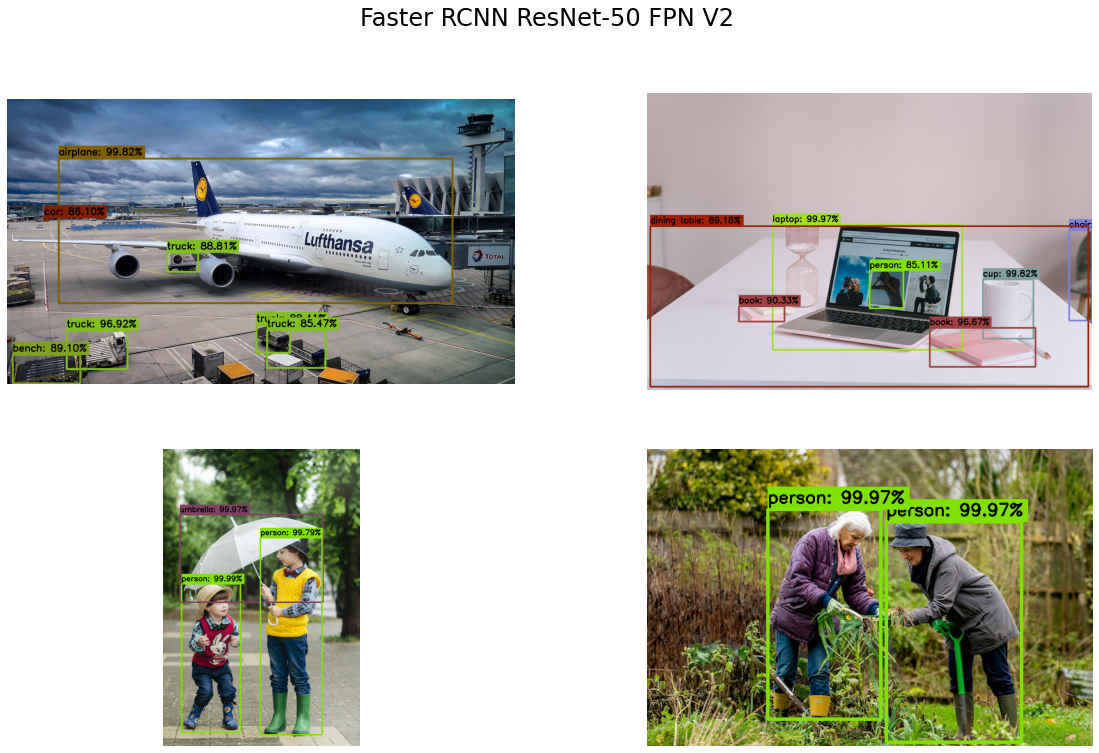

In [ ]:
category_index = weights_fasterrcnn_r50_v2.meta['categories']
visualize_results(images, predictions_fasterrcnn, category_index, score_thresh=0.85, title = 'Faster RCNN ResNet-50 FPN V2')

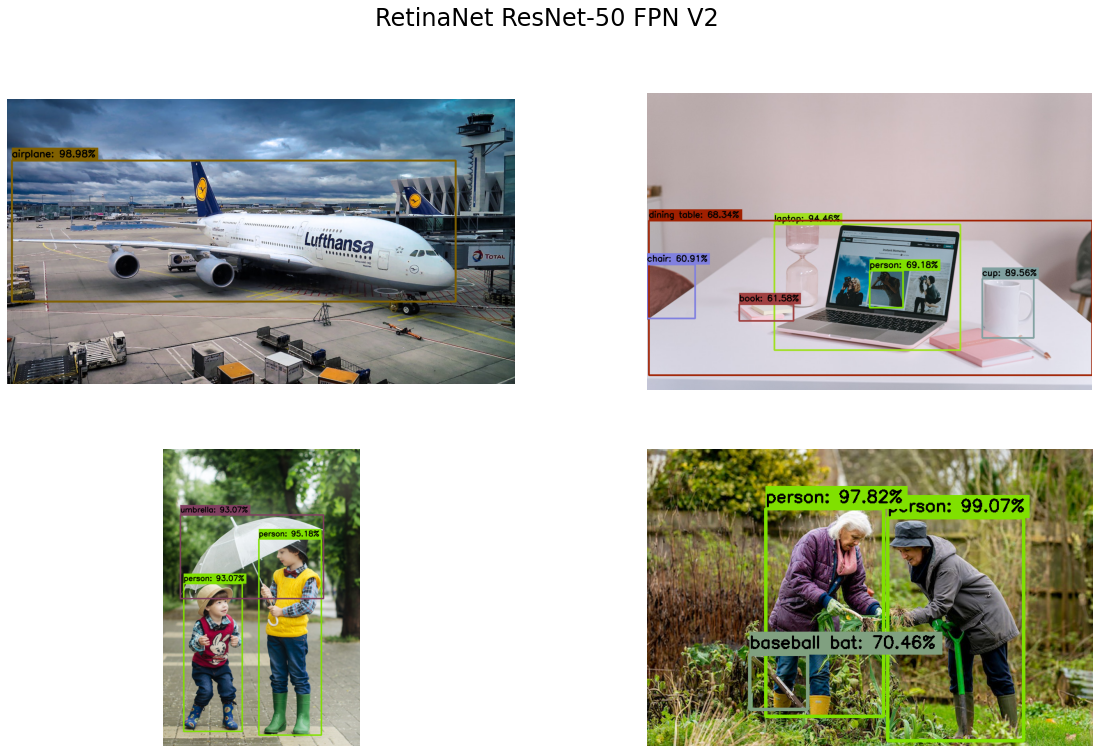

In [ ]:
category_index = weights_ssd300_vgg16.meta['categories']
visualize_results(images, predictions_retinanet, category_index, score_thresh=0.6, title = 'RetinaNet ResNet-50 FPN V2')

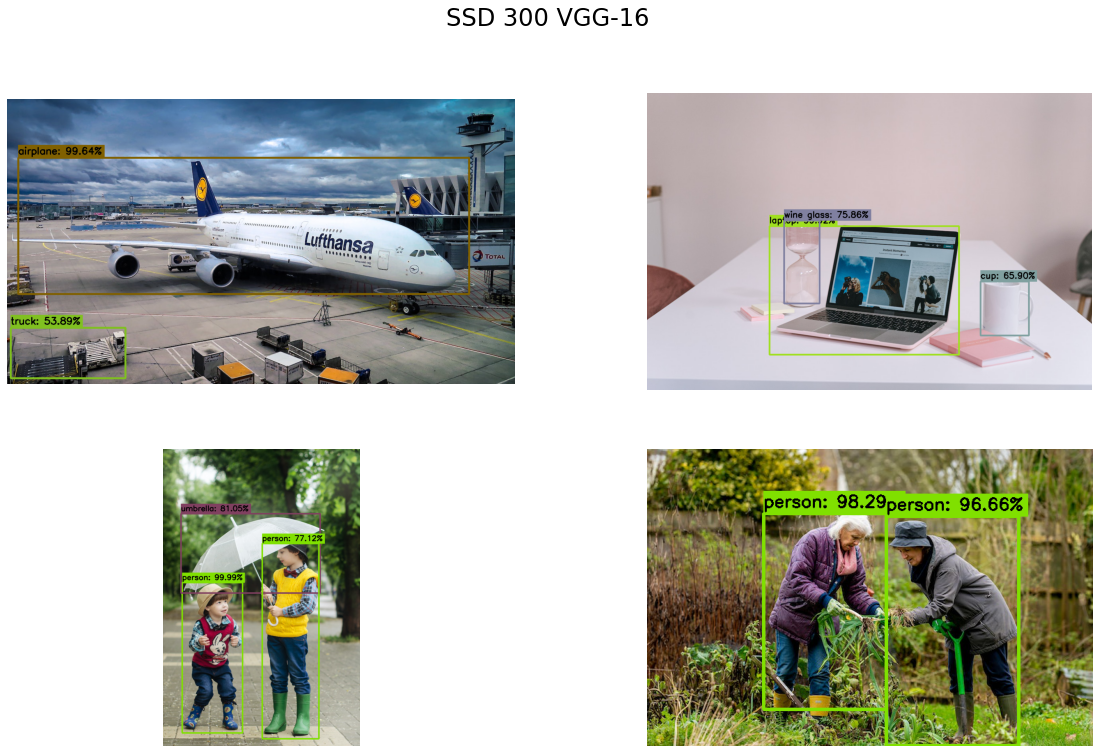

In [ ]:
category_index = weights_retinanet_r50_v2.meta['categories']
visualize_results(images, predictions_ssd, category_index, title = 'SSD 300 VGG-16')

From the above inference results, we can see that Faster RCNN provides the best results among the three.

## 4 References

- [Pre-trained Object Detection in Torchvision](https://pytorch.org/vision/0.14/models.html#object-detection)

- [Torchvision Faster RCNN models backbones](https://pytorch.org/vision/0.14/models/faster_rcnn.html)

- [RetinaNet with ResNet-50 FPN v2](https://pytorch.org/vision/0.14/models/generated/torchvision.models.detection.retinanet_resnet50_fpn_v2.html#retinanet-resnet50-fpn-v2)

- [SSD-300 with VGG-16](https://pytorch.org/vision/0.14/models/generated/torchvision.models.detection.ssd300_vgg16.html#ssd300-vgg16)
